In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


/tmp/ipykernel_125830/3232720673.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class BearLakeDataset(Dataset):
    def __init__(self, input_df, period_days, use_wateryear=False):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = StandardScaler()
        self.df.iloc[:, 2:] = self.scaler.fit_transform(self.df.iloc[:, 2:].values)
        self.period = period_days
        # Calculate the water year min/max if the period is longer than 365 days
        self.use_wateryear = use_wateryear
        if use_wateryear and period_days >= 365:
            self.tmp_df = self.df[['date', 'Elevation']].copy()
            self.tmp_df['month'] = self.tmp_df['date'].dt.month
            self.tmp_df['date']  = self.tmp_df['date'].dt.year
            # Convert year to water year
            def water_year(row):
                if row['month'] >= 10:  # October is month 10
                    return pd.Period(year=row['date'] + 1, freq='Y-SEP')
                else:
                    return pd.Period(year=row['date'], freq='Y-SEP')
            self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
            # Find min/max
            self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        len = self.df.shape[0] - self.period
        return len + 1
    
    def __getitem__(self, index):
        X = self.df.iloc[index:index+self.period, 2:].values
        if self.use_wateryear and self.period >= 365:
            last_year = self.df.iloc[index + self.period-1].date.year
            Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
            y_m = Y['min'].values
            y_M = Y['max'].values
            Ys = np.array([y_m, y_M]).flatten()
        else:
            Y = self.df.iloc[index:index+self.period, 1].values
            y_m = Y.min()
            y_M = Y.max()
            Ys = np.array([y_m, y_M])
            
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)


In [3]:
class BearLakeTestset(Dataset):
    def __init__(self, input_df, test_years, scaler, period=3*365, use_wateryear=True):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = scaler
        self.df.iloc[:, 2:] = self.scaler.transform(self.df.iloc[:, 2:].values)
        # Calculate the water year min/max if the period is longer than 365 days
        self.tmp_df = self.df[['date', 'Elevation']].copy()
        self.tmp_df['month'] = self.tmp_df['date'].dt.month
        self.tmp_df['date']  = self.tmp_df['date'].dt.year
        # Convert year to water year
        self.test_years = test_years
        self.period = period
        self.use_wateryear = use_wateryear

        def water_year(row):
            if row['month'] >= 10:  # October is month 10
                return pd.Period(year=row['date'] + 1, freq='Y-SEP')
            else:
                return pd.Period(year=row['date'], freq='Y-SEP')
        self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
        # self.df['wyear'] = self.df.apply(water_year, axis=1)
        # Find min/max
        self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        return self.test_years
    
    def __getitem__(self, index):
        X = self.df.iloc[index*365:self.period+(365*index), 2:].values
        if self.use_wateryear:
            last_year = self.df.iloc[self.period+(365*index)-1].date.year
            Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
            y_m = Y['min'].values
            y_M = Y['max'].values
            Ys = np.array([y_m, y_M]).flatten()
        else:
            Y = self.df.iloc[index*365:self.period+(365*index), 1].values
            y_m = Y.min()
            y_M = Y.max()
            Ys = np.array([y_m, y_M])        
    
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)



In [4]:
class BearLakeWaterYear(Dataset):
    def __init__(self, df, period, scaler=None):
        self.period = period
        self.df = df
        self.df['Elevation'] = self.df['Elevation'].interpolate(method="linear")
        if scaler is None:
            self.scaler = StandardScaler()
            self.df.iloc[:, 2:] = self.scaler.fit_transform(df.iloc[:, 2:].values)
        else:
            self.scaler = scaler
            self.df.iloc[:, 2:] = self.scaler.transform(df.iloc[:, 2:].values)
        
        self.Xs = self.df.iloc[:, 2:]
        self.Ys = self.df.iloc[:, :2]

        self.Ys['month'] = self.Ys['date'].dt.month
        self.Ys['year'] = self.Ys['date'].dt.year

        def water_year(row):
            if row['month'] >= 10:
                return pd.Period(year=row['year']+1, freq='Y-SEP')
            else:
                return pd.Period(year=row['year'], freq='Y-SEP')
        self.Ys['year'] = self.Ys.apply(water_year, axis=1)

        self.wyear_elevations = self.Ys.groupby('year')['Elevation'].agg(['min', 'max']).reset_index()
        self.wyear_elevations = self.wyear_elevations.iloc[(self.period - 1):].reset_index(drop=True)

    def __len__(self):
        return self.wyear_elevations.shape[0]
    
    def __getitem__(self, idx):
        year = self.wyear_elevations.year.iloc[idx].year
        last_day_idx = self.Ys[self.Ys['year'].dt.year == year].date.idxmax()
        X = self.Xs.iloc[last_day_idx-(365*self.period)+1:last_day_idx+1].values
        Y = self.wyear_elevations.iloc[idx, 1:3].values.astype(np.float32)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [5]:
# Define the GRU model
class GRU_MME(nn.Module):
    def __init__(self, input_size=60, hidden_size=10, output_size=2, num_layers=2, dropout=0.50,
                 scale=20, shift=5914.26, n_en=100, seed=789):
        super(GRU_MME, self).__init__()
        self.scale = scale
        self.shift = shift
        self.n_en = n_en
        self.seed = seed

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.act = nn.Tanh()
        self.do = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.serial = nn.Sequential(
            self.do, self.act, self.fc, self.act
        )

    def __hidden_forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0.detach())
        linear_outputs = self.scale * self.serial(out) + self.shift
        std, mean = torch.std_mean(linear_outputs, dim=1)
        return mean, std
    
    def forward(self, x):
        if self.training:
            mean, std = self.__hidden_forward(x)
        else:
            self.train()
            with torch.no_grad():
                torch.manual_seed(self.seed)
                mean, _ = self.__hidden_forward(x)
                preds = [mean]
                for i in range(1, self.n_en):
                    m, _ = self.__hidden_forward(x)
                    preds.append(m)
                preds = torch.stack(preds)
                mean = preds.mean(0)
                std = preds.std(0)
            self.eval()
        return mean, std

# Final Model Configurations

in: 60
hidden: 10
out: 2
layers: 2
dropout: 50%
scale: 20
shift: 5914.26
ensemble: 100

First train for 75 epochs using 3 year min/max  
Second train for 275 epochs using wateryears  

This model just uses L1 losses while training.

In [8]:
# Define hyperparameters
num_epochs_all = [75, 75]
batch_size = 1024
learning_rate = 5e-4
torch.manual_seed(789)
device_id = 2
if torch.cuda.is_available():
    device = f"cuda:{device_id}"
else:
    device = 'cpu'
model_prepend = 'sub_pt1'


# Instantiate the GRU model
model = GRU_MME()
# model.load_state_dict(torch.load(f"gru_model_{0}.pth"))
model.to(device)
# torch.autograd.set_detect_anomaly(True)

# Define loss function and optimizer
mse = nn.MSELoss()
l1 = nn.L1Loss()


n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily = daily.iloc[:, 0:82-20]
# daily_train = daily.iloc[:-period].reset_index(drop=True)
# daily_test = daily.iloc[-period:].reset_index(drop=True)
daily_train = daily.copy()
daily_test = daily.copy()
# Set up training and testing sets
period = 3

# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Training loop
training_loss_all = []
training_loss_epoch = []
wy_loss_epoch = []
wy_loss = 0
try:
    for i, wateryear in enumerate([False]):
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        if wateryear:
            dataset_train = BearLakeWaterYear(daily_train, period, scaler)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        else:
            dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            
        num_epochs = num_epochs_all[i]
        # Train over epochs
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            tmp_epoch_loss = []
            model.train()
            for batch_X, batch_Ys in dataloader:
                batch_X = batch_X.to(device)
                batch_Ys = batch_Ys.to(device)
                # Forward pass
                outputs, std = model(batch_X)
                # Compute the loss
                loss = mse(outputs, batch_Ys) + l1(outputs, batch_Ys)
                # loss = l1(outputs, batch_Ys)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(f"Train Loss: {loss.item():.2f};\tWater Year L1: {wy_loss:.2f}")
                training_loss_all.append(loss.item())
                tmp_epoch_loss.append(loss.item())
            training_loss_epoch.append(np.mean(tmp_epoch_loss))

            # Eval model
            model.eval()
            with torch.no_grad():
                tmp_loss = 0
                for batch_X, batch_Ys in dataloader_test_wy:
                    batch_X = batch_X.to(device)
                    batch_Ys = batch_Ys.to(device)
                    outputs, std = model(batch_X)
                    
                    loss = l1(outputs, batch_Ys)
                    tmp_loss += loss.item()
                wy_loss_epoch.append(tmp_loss/len(dataloader_test_wy))
            wy_loss = wy_loss_epoch[-1]
            
            # Save the trained model if needed
            torch.save(model.state_dict(), f'{model_prepend}_gru_model_{i}.pth')
except:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')
finally:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')

Train Loss: 2.74;	Water Year L1: 2.57: 100%|██████████| 75/75 [19:35<00:00, 15.68s/it] 


41 2.544851303100586


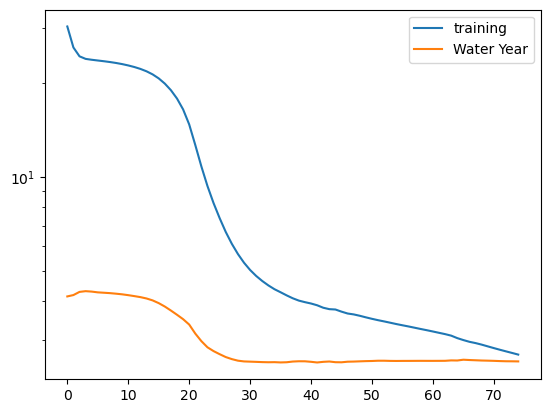

In [9]:
plt.plot(training_loss_epoch, label='training')
plt.plot(wy_loss_epoch, label='Water Year')
plt.legend()
plt.yscale("log")
# plt.savefig("pt2Training_final")

print(np.argmin(wy_loss_epoch), np.min(wy_loss_epoch))

In [10]:
# Define hyperparameters
num_epochs_all = [300, 275]
batch_size = 1024
learning_rate = 5e-4
torch.manual_seed(789)
device_id = 0
if torch.cuda.is_available():
    device = f"cuda:{device_id}"
else:
    device = 'cpu'
model_prepend = 'sub_pt2'


# Instantiate the GRU model
model = GRU_MME()
model.load_state_dict(torch.load(f"sub_pt1_gru_model_final.pth"))
model.to(device)
# torch.autograd.set_detect_anomaly(True)

# Define loss function and optimizer
mse = nn.MSELoss()
l1 = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily = daily.iloc[:, 0:82-20]
daily_train = daily.iloc[:-period].reset_index(drop=True)
daily_test = daily.iloc[-period:].reset_index(drop=True)
# daily_train = daily.copy()
# daily_test = daily.copy()
# Set up training and testing sets
period = 3

# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


# Training loop
training_loss_all = []
training_loss_epoch = []
wy_loss_epoch = []
wy_loss = 0
try:
    for i, wateryear in enumerate([True]):
        i = 1
        if wateryear:
            dataset_train = BearLakeWaterYear(daily_train, period, scaler)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        else:
            dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
            
        num_epochs = num_epochs_all[i]
        # Train over epochs
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            tmp_epoch_loss = []
            model.train()
            for batch_X, batch_Ys in dataloader:
                batch_X = batch_X.to(device)
                batch_Ys = batch_Ys.to(device)
                # Forward pass
                outputs, std = model(batch_X)
                # Compute the loss
                loss = mse(outputs, batch_Ys) + l1(outputs, batch_Ys)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(f"Train MSE+L1: {loss.item():.2f};\tWater Year L1: {wy_loss:.2f}")
                training_loss_all.append(loss.item())
                tmp_epoch_loss.append(loss.item())
            training_loss_epoch.append(np.mean(tmp_epoch_loss))

            # Eval model
            model.eval()
            with torch.no_grad():
                tmp_loss = 0
                for batch_X, batch_Ys in dataloader_test_wy:
                    batch_X = batch_X.to(device)
                    batch_Ys = batch_Ys.to(device)
                    outputs, std = model(batch_X)
                    
                    loss = l1(outputs, batch_Ys)
                    tmp_loss += loss.item()
                wy_loss_epoch.append(tmp_loss/len(dataloader_test_wy))
            wy_loss = wy_loss_epoch[-1]
            
            # Save the trained model if needed
            torch.save(model.state_dict(), f'{model_prepend}_gru_model_{i}.pth')
except:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')
finally:
    torch.save(model.state_dict(), f'{model_prepend}_gru_model_final.pth')

Train MSE+L1: 1.47;	Water Year L1: 2.48: 100%|██████████| 275/275 [00:57<00:00,  4.74it/s]


(274, 2.4732911586761475)

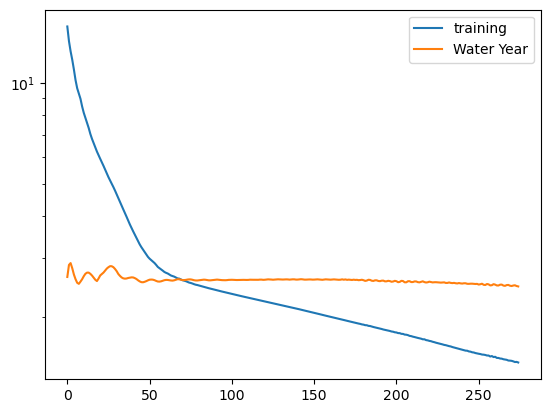

In [11]:
plt.plot(training_loss_epoch, label='training')
plt.plot(wy_loss_epoch, label='Water Year')
plt.legend()
plt.yscale("log")
# plt.savefig("pt2Training_final")

np.argmin(wy_loss_epoch), np.min(wy_loss_epoch)

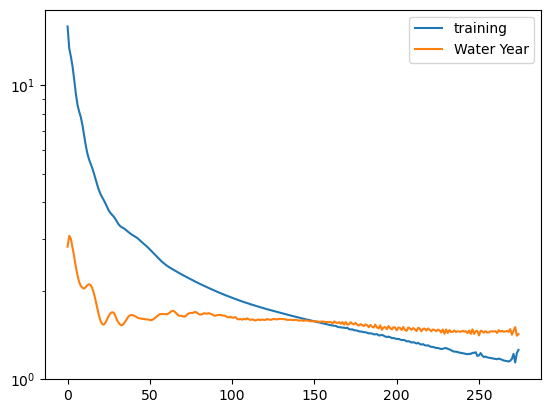

In [51]:
plt.plot(training_loss_epoch, label='training')
plt.plot(wy_loss_epoch, label='Water Year')
plt.legend()
plt.yscale("log")
# plt.savefig("pt2Training_final")

np.argmin(wy_loss_epoch), np.min(wy_loss_epoch)

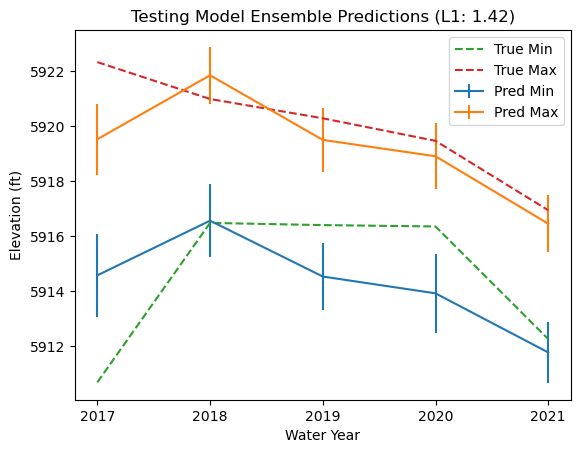

var_weighted R^2: 0.25919681699454655
raw R^2: [0.18863879 0.39291084]


In [7]:
n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily = daily.iloc[:, 0:82-20]
daily_train = daily.iloc[:-period].reset_index(drop=True)
daily_test = daily.iloc[-period:].reset_index(drop=True)
# daily_train = daily.copy()
# daily_test = daily.copy()
# Set up training and testing sets
period = 3
# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=1024, shuffle=False)
l1 = nn.L1Loss()
model = GRU_MME()
model.load_state_dict(torch.load("data/other/testingModels/sub/sub_pt2_gru_model_final.pth"))
device = 'cuda:3'
# device = 'cpu'
model.to(device)




predictions = []
torch.manual_seed(789)
model.eval()
with torch.no_grad():
    for batch_X, batch_Ys in dataloader_test_wy:
        batch_X = batch_X.to(device)
        batch_Ys = batch_Ys.to(device)
        means, stds = model(batch_X)
        loss = l1(means, batch_Ys)
means = means.detach().cpu().numpy()
stds = 3*stds.detach().cpu().numpy()
import matplotlib.ticker as mticker
plt.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
plt.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
plt.plot(dataset_test.wyear_elevations.year.dt.year.values, dataset_test.wyear_elevations.iloc[:, 1:3].values[:, 0], label='True Min', linestyle='--')
plt.plot(dataset_test.wyear_elevations.year.dt.year.values, dataset_test.wyear_elevations.iloc[:, 1:3].values[:, 1], label='True Max', linestyle='--')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend()
plt.title(f"Testing Model Ensemble Predictions (L1: {loss.item():.2f})")
plt.xlabel("Water Year")
plt.ylabel("Elevation (ft)")
plt.show()



print(f'var_weighted R^2: {r2_score(dataset_test.wyear_elevations.iloc[:, 1:3].values[:, :], means[:, :], multioutput="variance_weighted")}')
print(f'raw R^2: {r2_score(dataset_test.wyear_elevations.iloc[:, 1:3].values[:, :], means[:, :], multioutput="raw_values")}')

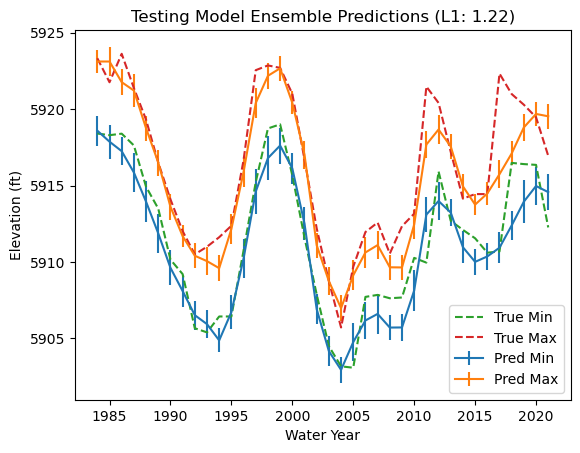

var_weighted R^2: 0.8795382583440889
raw R^2: [0.89283528 0.86732368]


In [12]:
n_test_years = 5
period = (n_test_years+2)*365+2
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily = daily.iloc[:, 0:82-20]
# daily_train = daily.iloc[:-period].reset_index(drop=True)
# daily_test = daily.iloc[-period:].reset_index(drop=True)
daily_train = daily.copy()
daily_test = daily.copy()
# Set up training and testing sets
period = 3
# To have a standard scaler
dataset_train = BearLakeDataset(daily_train, period_days=period*365, use_wateryear=False)
scaler = dataset_train.scaler
dataset_test = BearLakeWaterYear(daily_test, period, scaler)
dataloader_test_wy = DataLoader(dataset_test, batch_size=1024, shuffle=False)
l1 = nn.L1Loss()
model = GRU_MME()
model.load_state_dict(torch.load("sub_pt2_gru_model_final.pth"))
device = 'cuda:3'
# device = 'cpu'
model.to(device)




predictions = []
torch.manual_seed(789)
model.eval()
with torch.no_grad():
    for batch_X, batch_Ys in dataloader_test_wy:
        batch_X = batch_X.to(device)
        batch_Ys = batch_Ys.to(device)
        means, stds = model(batch_X)
        loss = l1(means, batch_Ys)
means = means.detach().cpu().numpy()
stds = 3*stds.detach().cpu().numpy()

plt.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 0], yerr=stds[:, 0], label='Pred Min')
plt.errorbar(x=dataset_test.wyear_elevations.year.dt.year.values, y=means[:, 1], yerr=stds[:, 1], label='Pred Max')
plt.plot(dataset_test.wyear_elevations.year.dt.year.values, dataset_test.wyear_elevations.iloc[:, 1:3].values[:, 0], label='True Min', linestyle='--')
plt.plot(dataset_test.wyear_elevations.year.dt.year.values, dataset_test.wyear_elevations.iloc[:, 1:3].values[:, 1], label='True Max', linestyle='--')

plt.legend()
plt.title(f"Testing Model Ensemble Predictions (L1: {loss.item():.2f})")
plt.xlabel("Water Year")
plt.ylabel("Elevation (ft)")
plt.show()



print(f'var_weighted R^2: {r2_score(dataset_test.wyear_elevations.iloc[:, 1:3].values[:, :], means[:, :], multioutput="variance_weighted")}')
print(f'raw R^2: {r2_score(dataset_test.wyear_elevations.iloc[:, 1:3].values[:, :], means[:, :], multioutput="raw_values")}')